<div class="alert alert-success"> 
        <h1 align="center" style="color:chocolate;">KANs for Domain Incremental Learning
</h1>  
     
</div>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: white; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>Overview</font></h3>
    
* In this notebook I implement a Kolmogorov-Arnold Network (KAN) for Loan Approval Prediction and compare it against a neural network of a similar architecture.
* this dataset has more data than breast canser prediction and we want to assess KANs on larger datasets.
* The dataset is from Kaggle, available at this https://www.kaggle.com/competitions/playground-series-s4e10
    



# Import Packages


In [1]:
import torch
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np  

device = 'cpu'

## Loading the Dataset

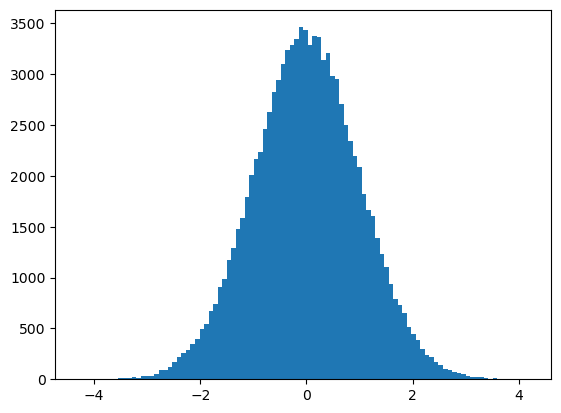

In [2]:
x = plt.hist(np.random.normal(size=100000),bins=100)

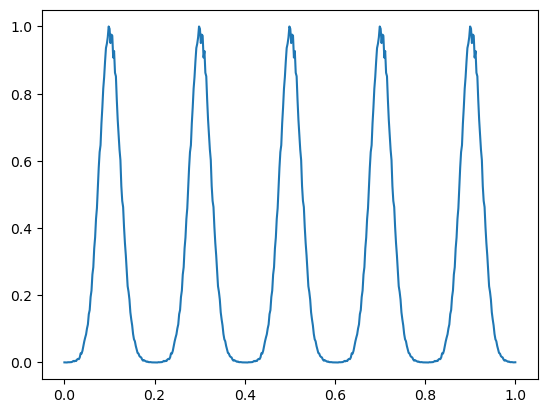

In [3]:
y_data = list(x[0]/(max(x[0])-min(x[0])))*5
x_data = list(np.linspace(0,1,500))
plt.plot(x_data,y_data)

In [4]:
model = KAN(width=[1,1], grid=2000, k=3, noise_scale=0.1, sp_trainable=False, sb_trainable=False, base_fun='zero')

checkpoint directory created: ./model
saving model version 0.0


In [5]:
for group in range(5):
    dataset = {}
    dataset['train_input'] = torch.tensor(x_data[group*100:(group+1)*100], dtype=torch.float32).unsqueeze(1)
    dataset['test_input'] = torch.tensor(x_data[group*100:(group+1)*100], dtype=torch.float32).unsqueeze(1)
    dataset['train_label'] = torch.tensor(y_data[group*100:(group+1)*100], dtype=torch.float32).unsqueeze(1)
    dataset['test_label'] = torch.tensor(y_data[group*100:(group+1)*100], dtype=torch.float32).unsqueeze(1)

    results = model.fit(dataset, opt="LBFGS", update_grid=False, steps=100)

| train_loss: 1.65e-08 | test_loss: 1.65e-08 | reg: 3.67e+00 | : 100%|â–ˆ| 100/100 [00:03<00:00, 27.18


saving model version 0.1


| train_loss: 7.89e-09 | test_loss: 7.89e-09 | reg: 3.67e+00 | : 100%|â–ˆ| 100/100 [00:02<00:00, 47.03


saving model version 0.2


| train_loss: 8.86e-09 | test_loss: 8.86e-09 | reg: 3.67e+00 | : 100%|â–ˆ| 100/100 [00:02<00:00, 42.50


saving model version 0.3


| train_loss: 1.30e-08 | test_loss: 1.30e-08 | reg: 3.67e+00 | : 100%|â–ˆ| 100/100 [00:02<00:00, 43.83


saving model version 0.4


| train_loss: 1.56e-08 | test_loss: 1.56e-08 | reg: 3.67e+00 | : 100%|â–ˆ| 100/100 [00:02<00:00, 43.43

saving model version 0.5


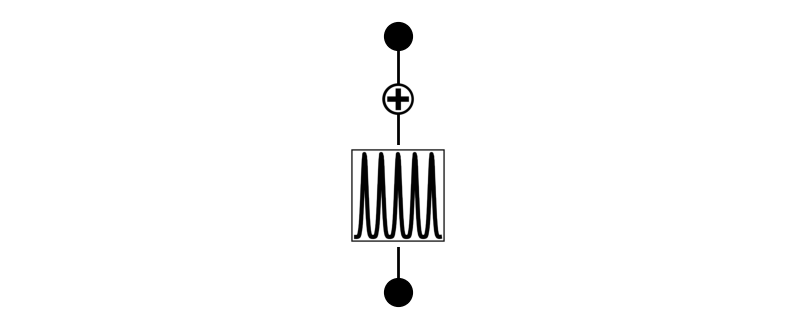

In [6]:
x_pred = model(torch.tensor(np.linspace(0,1,500), dtype=torch.float32).unsqueeze(1))
model.plot(scale=1)

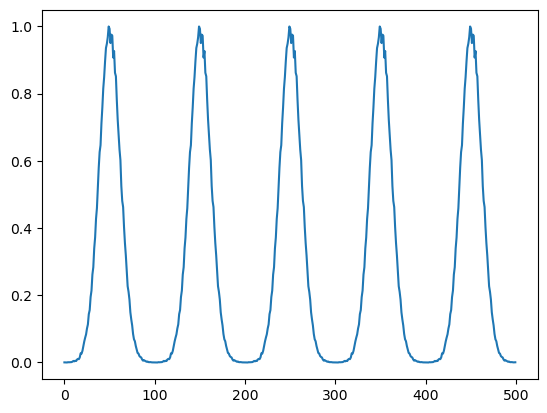

In [7]:
plt.plot(x_pred.detach())

In [8]:
from torch import nn
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(1, 50)  # 4 inputs to 5 hidden nodes
        self.relu = nn.Sigmoid()
        self.fc2 = nn.Linear(50, 50) 
        self.relu = nn.Sigmoid()
        self.fc3 = nn.Linear(50, 1)  # 5 hidden nodes to 3 outputs

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def test_model(model, test_loader):
    model.eval()
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            outputs = model(inputs)
            loss = torch.nn.functional.mse_loss(outputs, labels, reduction='sum')
            total_loss += loss.item()
            total_count += labels.size(0)

    # Calculate the average MSE over all batches
    average_mse = total_loss / total_count
    print(f'Mean Squared Error: {average_mse}')

In [9]:
def load_dataset(dataset):
    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(dataset['train_input'], dataset['train_label']), batch_size=1000, shuffle=False)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(dataset['test_input'], dataset['test_label']), batch_size=1000, shuffle=False)

    return train_loader, test_loader

In [10]:
N=10000
model = NeuralNetwork().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

for group in range(5):
    dataset = {}
    dataset['train_input'] = torch.tensor(x_data[group*100:(group+1)*100], dtype=torch.float32).unsqueeze(1)
    dataset['test_input'] = torch.tensor(x_data[group*100:(group+1)*100], dtype=torch.float32).unsqueeze(1)
    dataset['train_label'] = torch.tensor(y_data[group*100:(group+1)*100], dtype=torch.float32).unsqueeze(1)
    dataset['test_label'] = torch.tensor(y_data[group*100:(group+1)*100], dtype=torch.float32).unsqueeze(1)
    
    train_loader, test_loader = load_dataset(dataset)
    loss_list = train_model(model, train_loader, criterion, optimizer, num_epochs=N)
    test_model(model, train_loader)
    test_model(model, test_loader)

Epoch 1, Loss: 0.14394806325435638
Epoch 2, Loss: 0.13083912432193756
Epoch 3, Loss: 0.12224073708057404
Epoch 4, Loss: 0.11791510879993439
Epoch 5, Loss: 0.11717603355646133
Epoch 6, Loss: 0.11875360459089279
Epoch 7, Loss: 0.12102798372507095
Epoch 8, Loss: 0.12267529219388962
Epoch 9, Loss: 0.12312227487564087
Epoch 10, Loss: 0.12245504558086395
Epoch 11, Loss: 0.12109391391277313
Epoch 12, Loss: 0.11953303217887878
Epoch 13, Loss: 0.11819282174110413
Epoch 14, Loss: 0.11734553426504135
Epoch 15, Loss: 0.11708411574363708
Epoch 16, Loss: 0.11732762306928635
Epoch 17, Loss: 0.11786699295043945
Epoch 18, Loss: 0.11844430863857269
Epoch 19, Loss: 0.11884056031703949
Epoch 20, Loss: 0.11893735080957413
Epoch 21, Loss: 0.11873313784599304
Epoch 22, Loss: 0.11831910163164139
Epoch 23, Loss: 0.117833212018013
Epoch 24, Loss: 0.11741185933351517
Epoch 25, Loss: 0.11715119332075119
Epoch 26, Loss: 0.11708565801382065
Epoch 27, Loss: 0.11718650907278061
Epoch 28, Loss: 0.11737925559282303
Epo

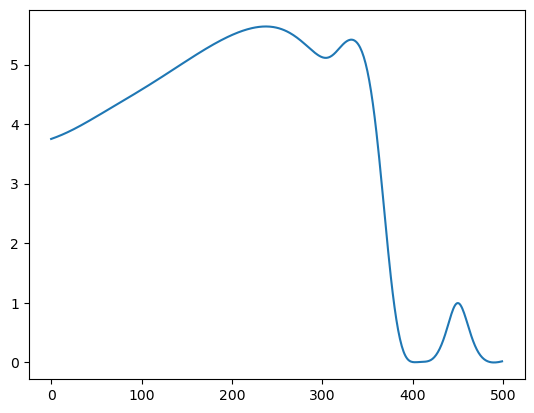

In [11]:
x_pred = model(torch.tensor(np.linspace(0,1,500), dtype=torch.float32).unsqueeze(1))
plt.plot(x_pred.detach())

In [12]:
digits = load_digits(n_class=10, as_frame=True)
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [13]:
# from sklearn.datasets import fetch_openml
# digits = fetch_openml('mnist_784')

In [14]:
data = digits.data.join(pd.to_numeric(digits.target))
data.head()

pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
0        0.0        0.0        5.0       13.0        9.0        1.0   
1        0.0        0.0        0.0       12.0       13.0        5.0   
2        0.0        0.0        0.0        4.0       15.0       12.0   
3        0.0        0.0        7.0       15.0       13.0        1.0   
4        0.0        0.0        0.0        1.0       11.0        0.0   

   pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_7  pixel_7_0  \
0        0.0        0.0        0.0        0.0  ...        0.0        0.0   
1        0.0        0.0        0.0        0.0  ...        0.0        0.0   
2        0.0        0.0        0.0        0.0  ...        0.0        0.0   
3        0.0        0.0        0.0        8.0  ...        0.0        0.0   
4        0.0        0.0        0.0        0.0  ...        0.0        0.0   

   pixel_7_1  pixel_7_2  pixel_7_3  pixel_7_4  pixel_7_5  pixel_7_6  \
0        0.0        6.0       13.0       10.0        0.0        0.0   
1        0.0        0.0       11.0       16.0       10.0        0.0   
2        0.0        0.0        3.0       11.0       16.0        9.0   
3        0.0        7.0       13.0       13.0        9.0        0.0   
4        0.0        0.0        2.0       16.0        4.0        0.0   

   pixel_7_7  target  
0        0.0       0  
1        0.0       1  
2        0.0       2  
3        0.0       3  
4        0.0       4  

[5 rows x 65 columns]

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pixel_0_0  1797 non-null   float64
 1   pixel_0_1  1797 non-null   float64
 2   pixel_0_2  1797 non-null   float64
 3   pixel_0_3  1797 non-null   float64
 4   pixel_0_4  1797 non-null   float64
 5   pixel_0_5  1797 non-null   float64
 6   pixel_0_6  1797 non-null   float64
 7   pixel_0_7  1797 non-null   float64
 8   pixel_1_0  1797 non-null   float64
 9   pixel_1_1  1797 non-null   float64
 10  pixel_1_2  1797 non-null   float64
 11  pixel_1_3  1797 non-null   float64
 12  pixel_1_4  1797 non-null   float64
 13  pixel_1_5  1797 non-null   float64
 14  pixel_1_6  1797 non-null   float64
 15  pixel_1_7  1797 non-null   float64
 16  pixel_2_0  1797 non-null   float64
 17  pixel_2_1  1797 non-null   float64
 18  pixel_2_2  1797 non-null   float64
 19  pixel_2_3  1797 non-null   float64
 20  pixel_2_

<Axes: >

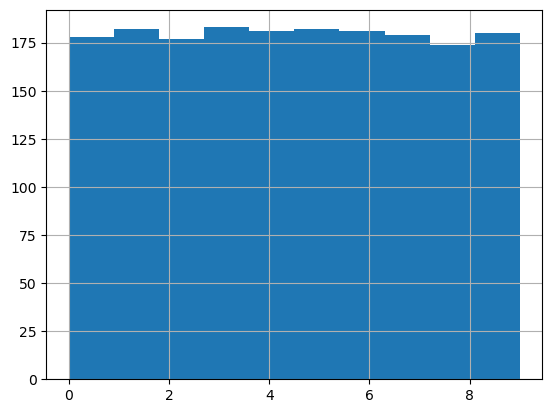

In [16]:
data.target.hist()

In [17]:
# Split dataset into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=1)

In [18]:
train_data

pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
1328        0.0        0.0        0.0        2.0       15.0        8.0   
1562        0.0        0.0        0.0        7.0       16.0       16.0   
750         0.0        0.0        0.0        6.0       11.0        0.0   
1788        0.0        0.0        0.0        1.0       12.0        6.0   
408         0.0        0.0        9.0       11.0        2.0        0.0   
...         ...        ...        ...        ...        ...        ...   
905         0.0        0.0        2.0        8.0        7.0        0.0   
1791        0.0        0.0        0.0        3.0       15.0        4.0   
1096        0.0        0.0        7.0       12.0       11.0        1.0   
235         0.0        0.0        0.0        0.0       10.0       13.0   
1061        0.0        0.0        8.0       15.0       16.0       16.0   

      pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_7  pixel_7_0  \
1328        0.0        0.0        0.0        0.0  ...        0.0        0.0   
1562       11.0        0.0        0.0        0.0  ...        0.0        0.0   
750         0.0        0.0        0.0        0.0  ...        3.0        0.0   
1788        0.0        0.0        0.0        0.0  ...        0.0        0.0   
408         0.0        0.0        0.0        8.0  ...        0.0        0.0   
...         ...        ...        ...        ...  ...        ...        ...   
905         0.0        0.0        0.0        0.0  ...        1.0        0.0   
1791        0.0        0.0        0.0        0.0  ...        0.0        0.0   
1096        0.0        0.0        0.0        0.0  ...        0.0        0.0   
235         7.0        0.0        0.0        0.0  ...        0.0        0.0   
1061        6.0        0.0        0.0        2.0  ...        0.0        0.0   

      pixel_7_1  pixel_7_2  pixel_7_3  pixel_7_4  pixel_7_5  pixel_7_6  \
1328        0.0        0.0        2.0       15.0        5.0        0.0   
1562        0.0        0.0       11.0        3.0        0.0        0.0   
750         0.0        0.0        5.0       11.0       13.0       12.0   
1788        0.0        0.0        0.0       14.0        9.0        0.0   
408         0.0        7.0        9.0        9.0       12.0        4.0   
...         ...        ...        ...        ...        ...        ...   
905         0.0        1.0       12.0       10.0        7.0        0.0   
1791        0.0        0.0        1.0       16.0        4.0        0.0   
1096        0.0        8.0       12.0       16.0       13.0        2.0   
235         0.0        0.0        2.0       13.0       16.0        1.0   
1061        0.0        9.0       16.0        8.0        0.0        0.0   

      pixel_7_7  target  
1328        0.0       4  
1562        0.0       9  
750         2.0       6  
1788        0.0       4  
408         0.0       2  
...         ...     ...  
905         0.0       8  
1791        0.0       4  
1096        0.0       9  
235         0.0       1  
1061        0.0       5  

[1437 rows x 65 columns]

## Preprocessing

In [19]:
def Preprocessing(data, n):
    #StandardScaler
    # (n-1)/10
    sacale = MinMaxScaler(((n-1)/10,n/10))
    target = data['target']
    data = sacale.fit_transform(data.drop(columns=['target']))
    # data = data*n/10
    return data, target.tolist()

In [20]:
def data_continual_learn(train_data, test_data, n):
    train_x, train_y = Preprocessing(train_data, n)
    test_x, test_y = Preprocessing(test_data, n)

    dataset = {}
    dataset['train_input'] = torch.tensor(train_x, dtype=torch.float32, device=device)
    dataset['test_input'] = torch.tensor(test_x, dtype=torch.float32, device=device)
    dataset['train_label'] = torch.tensor(train_y, dtype=torch.long, device=device)
    dataset['test_label'] = torch.tensor(test_y, dtype=torch.long, device=device)

    return dataset

In [21]:
train_x, train_y = Preprocessing(train_data, 5)
test_x, test_y = Preprocessing(test_data, 5)

In [22]:
test_x.min()

0.4

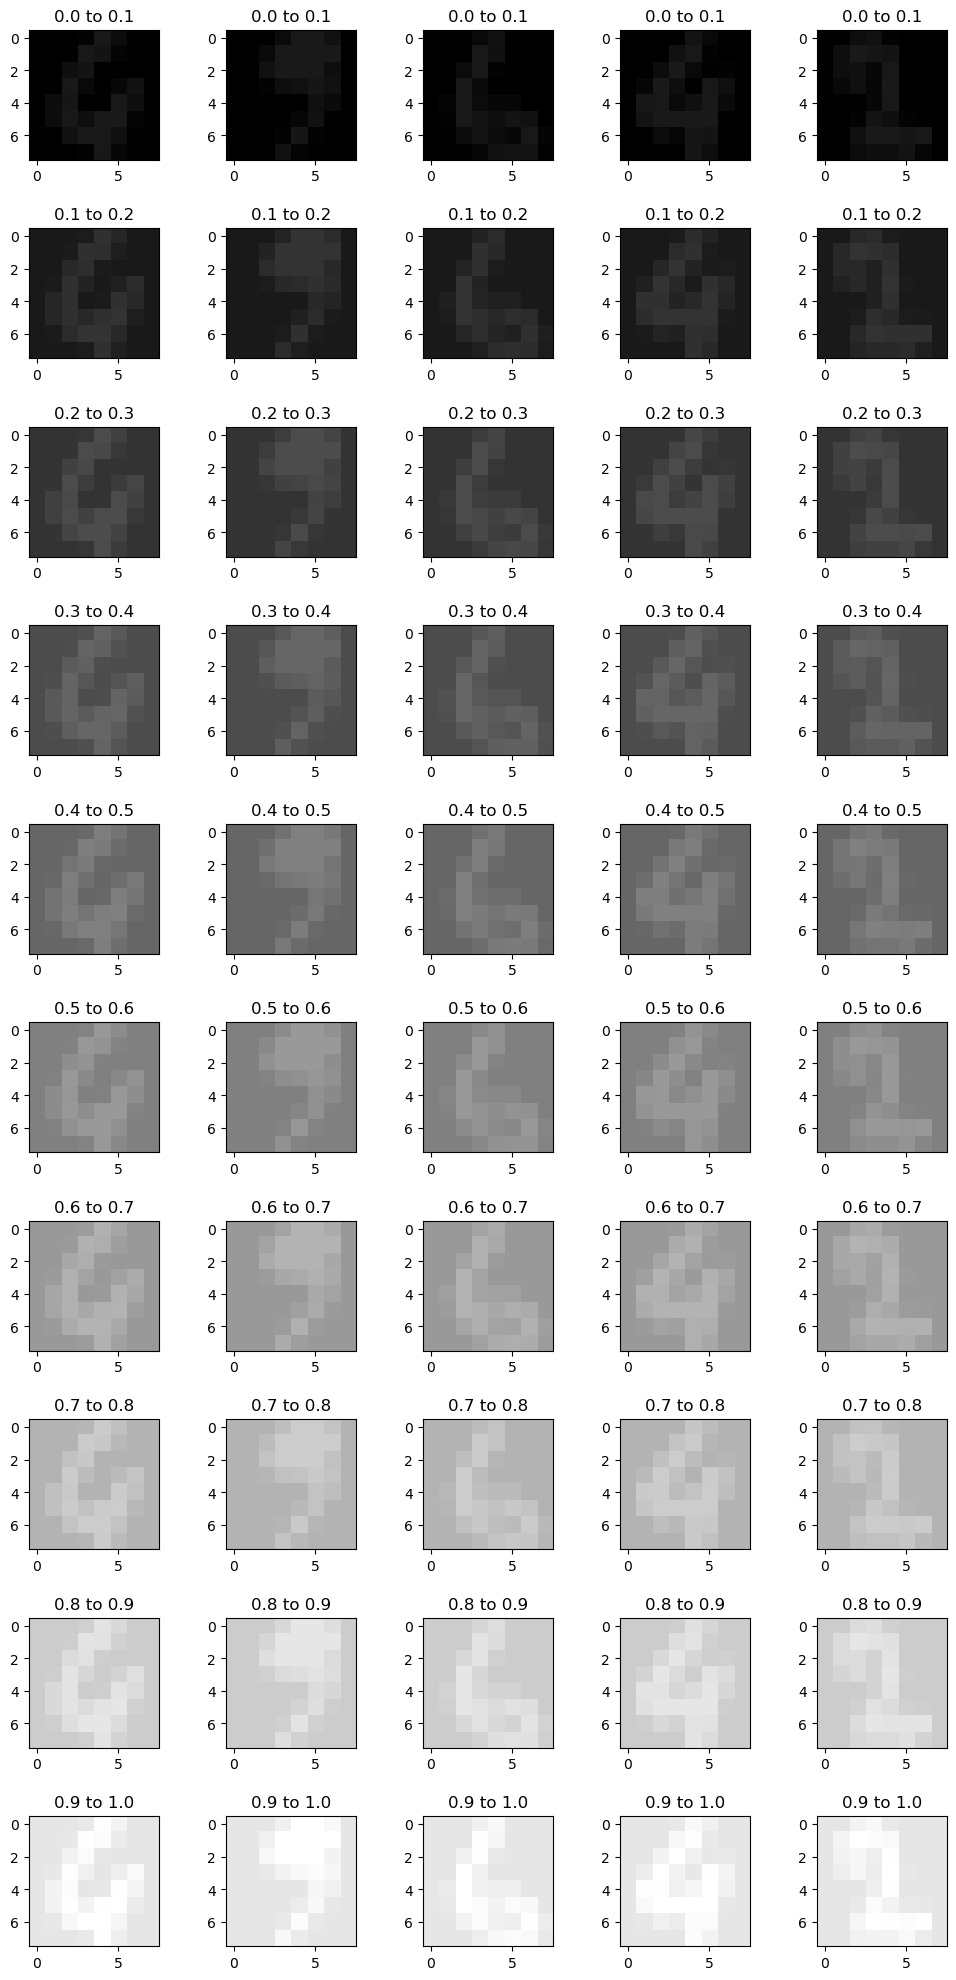

In [26]:
fig, ax = plt.subplots(10, 5, figsize=(10, 20))
fig.tight_layout()
for i in range(0, 10):
    for j in range(5):
        xx, yy = Preprocessing(train_data, i+1)
        ax[i,j].imshow(xx[j].reshape((8,8)) , cmap='gray', vmin=0, vmax=1)
        ax[i,j].set_title(str((i)/10) + ' to ' +str((i+1)/10))
plt.show()

## Prepare data for KAN

In [45]:
dataset = {}
dataset['train_input'] = torch.tensor(train_x, dtype=torch.float32, device=device)
dataset['test_input'] = torch.tensor(test_x, dtype=torch.float32, device=device)
dataset['train_label'] = torch.tensor(train_y, dtype=torch.long, device=device)
dataset['test_label'] = torch.tensor(test_y, dtype=torch.long, device=device)

In [46]:
dataset['train_input']

tensor([[0.4000, 0.4000, 0.4000,  ..., 0.4313, 0.4000, 0.4000],
        [0.4000, 0.4000, 0.4000,  ..., 0.4000, 0.4000, 0.4000],
        [0.4000, 0.4000, 0.4000,  ..., 0.4812, 0.4750, 0.4125],
        ...,
        [0.4000, 0.4000, 0.4437,  ..., 0.4812, 0.4125, 0.4000],
        [0.4000, 0.4000, 0.4000,  ..., 0.5000, 0.4062, 0.4000],
        [0.4000, 0.4000, 0.4500,  ..., 0.4000, 0.4000, 0.4000]])

In [47]:
print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print("Test data shape: {}".format(dataset['test_input'].shape))
print("Test target shape: {}".format(dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([1437, 64])
Train target shape: torch.Size([1437])
Test data shape: torch.Size([360, 64])
Test target shape: torch.Size([360])


## Creating and Training the KAN

In [48]:
from kan import KAN

model = KAN(width=[64, 10], grid=300, k=2, seed=0, device=device, noise_scale=10, sp_trainable=False, sb_trainable=True)#, base_fun='zero')

checkpoint directory created: ./model
saving model version 0.0


In [49]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

In [50]:
%%time
N=10
all_result=[]
for i in range(10):
    dataset = data_continual_learn(train_data, test_data, i+1)
    results = model.fit(dataset, 
                        opt="LBFGS",
                        metrics=(train_acc, test_acc),
                        loss_fn=torch.nn.CrossEntropyLoss(),
                        steps=N, update_grid=False)
    print('Training Accuracy :', results['train_acc'][-1])
    print('Test Accuracy :', results['test_acc'][-1])
    all_result.extend(results['train_loss'])

| train_loss: 1.58e-05 | test_loss: 6.28e-01 | reg: 6.09e+03 | : 100%|â–ˆ| 10/10 [00:41<00:00,  4.12s/


saving model version 0.1
Training Accuracy : 1.0
Test Accuracy : 0.9666666388511658


| train_loss: 1.29e-05 | test_loss: 5.53e-01 | reg: 5.07e+03 | : 100%|â–ˆ| 10/10 [00:38<00:00,  3.84s/


saving model version 0.2
Training Accuracy : 1.0
Test Accuracy : 0.9611111283302307


| train_loss: 0.00e+00 | test_loss: 5.54e-01 | reg: 5.36e+03 | : 100%|â–ˆ| 10/10 [00:41<00:00,  4.10s/


saving model version 0.3
Training Accuracy : 1.0
Test Accuracy : 0.9527778029441833


| train_loss: 0.00e+00 | test_loss: 6.02e-01 | reg: 6.23e+03 | : 100%|â–ˆ| 10/10 [00:42<00:00,  4.21s/


saving model version 0.4
Training Accuracy : 1.0
Test Accuracy : 0.9611111283302307


| train_loss: 0.00e+00 | test_loss: 5.87e-01 | reg: 5.76e+03 | : 100%|â–ˆ| 10/10 [00:44<00:00,  4.44s/


saving model version 0.5
Training Accuracy : 1.0
Test Accuracy : 0.9611111283302307


| train_loss: 2.58e-05 | test_loss: 5.94e-01 | reg: 5.33e+03 | : 100%|â–ˆ| 10/10 [00:43<00:00,  4.32s/


saving model version 0.6
Training Accuracy : 1.0
Test Accuracy : 0.9555555582046509


| train_loss: 2.88e-05 | test_loss: 6.18e-01 | reg: 6.24e+03 | : 100%|â–ˆ| 10/10 [00:39<00:00,  3.94s/


saving model version 0.7
Training Accuracy : 1.0
Test Accuracy : 0.9555555582046509


| train_loss: 3.02e-05 | test_loss: 5.52e-01 | reg: 5.44e+03 | : 100%|â–ˆ| 10/10 [00:47<00:00,  4.72s/


saving model version 0.8
Training Accuracy : 1.0
Test Accuracy : 0.9611111283302307


| train_loss: 3.02e-05 | test_loss: 5.91e-01 | reg: 5.46e+03 | : 100%|â–ˆ| 10/10 [00:43<00:00,  4.33s/


saving model version 0.9
Training Accuracy : 1.0
Test Accuracy : 0.9555555582046509


| train_loss: 4.37e-05 | test_loss: 5.23e-01 | reg: 5.08e+03 | : 100%|â–ˆ| 10/10 [00:43<00:00,  4.34s/

saving model version 0.10
Training Accuracy : 1.0
Test Accuracy : 0.9555555582046509
CPU times: total: 3min 14s
Wall time: 7min 3s


Text(0, 0.5, 'Loss')

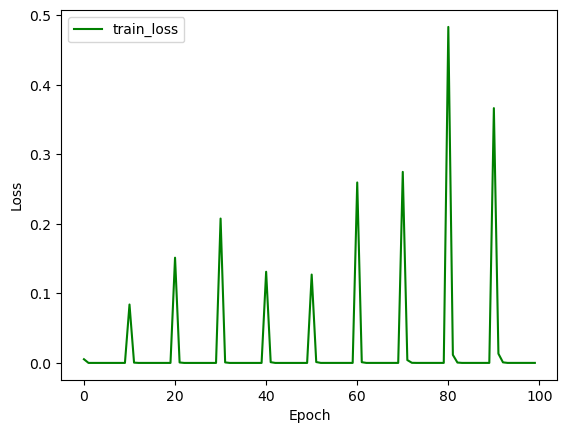

In [51]:
plt.plot(all_result, 'g', label='train_loss') 
#plt.plot(range(N),results['test_loss'], 'y', label='validation_loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [52]:
for i in range(10):
    dataset = data_continual_learn(train_data, test_data, i+1)
    # print('Training Accuracy :', train_acc())
    print('Test Accuracy :', test_acc())

Test Accuracy : tensor(0.9056)
Test Accuracy : tensor(0.8417)
Test Accuracy : tensor(0.7972)
Test Accuracy : tensor(0.8778)
Test Accuracy : tensor(0.8528)
Test Accuracy : tensor(0.7389)
Test Accuracy : tensor(0.8444)
Test Accuracy : tensor(0.8083)
Test Accuracy : tensor(0.8667)
Test Accuracy : tensor(0.9556)


In [53]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total trainable parameters :', params)

Total trainable parameters : 196480


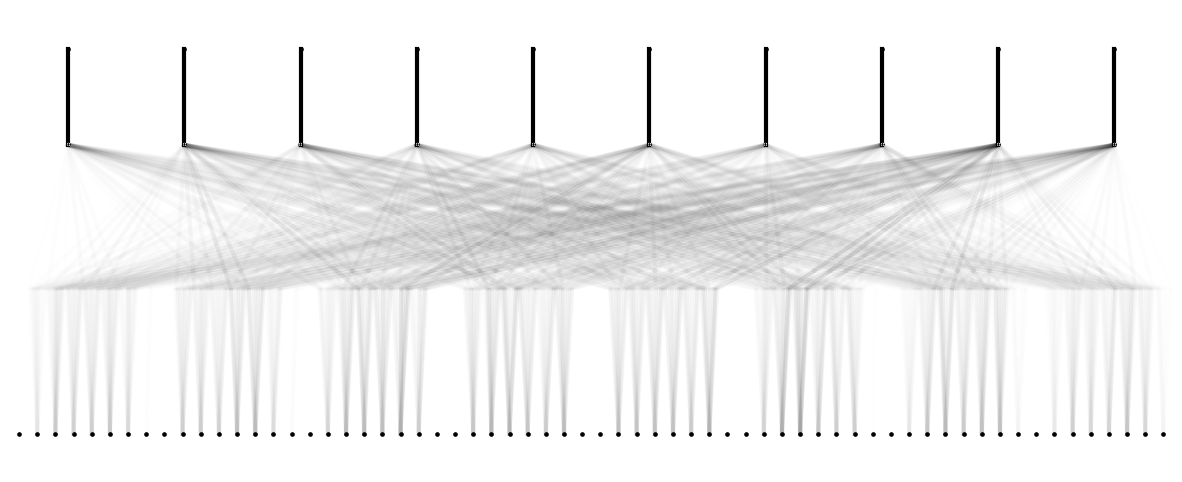

In [54]:
model.plot(scale=1.5)

# Implementation of a Neural Network for comparison

In [55]:
from torch import nn
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(64, 64)  # 4 inputs to 5 hidden nodes
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)  # 5 hidden nodes to 3 outputs

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        loss_list.append(loss.item())
        # print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    return loss_list

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

In [56]:
def load_dataset(dataset):
    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(dataset['train_input'], dataset['train_label']), batch_size=1000, shuffle=False)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(dataset['test_input'], dataset['test_label']), batch_size=1000, shuffle=False)

    return train_loader, test_loader


## Train and Evaluate the NN

In [57]:
%%time
N=1000
model = NeuralNetwork().to(device)

CPU times: total: 15.6 ms
Wall time: 6.77 ms


In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
all_loss=[]

for i in range(10):
    train_loader, test_loader = load_dataset(data_continual_learn(train_data, test_data, i+1))
    loss_list = train_model(model, train_loader, criterion, optimizer, num_epochs=N)
    all_loss.extend(loss_list)
    test_model(model, train_loader)
    test_model(model, test_loader)

Accuracy: 99.93041057759221%
Accuracy: 95.55555555555556%
Accuracy: 99.93041057759221%
Accuracy: 95.83333333333333%
Accuracy: 100.0%
Accuracy: 96.11111111111111%
Accuracy: 100.0%
Accuracy: 96.38888888888889%
Accuracy: 100.0%
Accuracy: 96.66666666666667%
Accuracy: 100.0%
Accuracy: 96.66666666666667%
Accuracy: 100.0%
Accuracy: 96.66666666666667%
Accuracy: 100.0%
Accuracy: 96.66666666666667%
Accuracy: 100.0%
Accuracy: 96.66666666666667%
Accuracy: 100.0%
Accuracy: 96.66666666666667%


Text(0, 0.5, 'Loss')

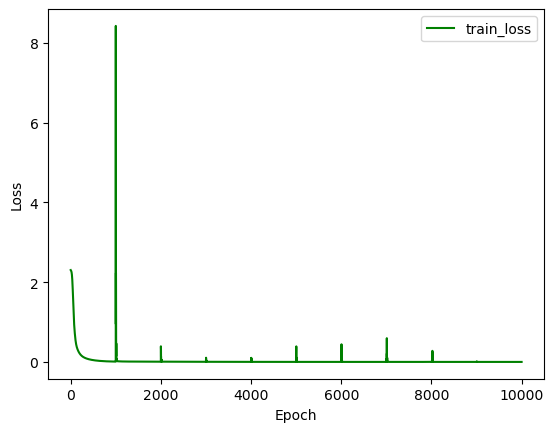

In [59]:
plt.plot(all_loss, 'g', label='train_loss') 
#plt.plot(range(N),results['test_loss'], 'y', label='validation_loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [60]:
for i in range(10):
    train_loader, test_loader = load_dataset(data_continual_learn(train_data, test_data, i+1))
    # test_model(model, train_loader)
    test_model(model, test_loader)

Accuracy: 49.44444444444444%
Accuracy: 56.388888888888886%
Accuracy: 62.22222222222222%
Accuracy: 68.05555555555556%
Accuracy: 75.0%
Accuracy: 83.05555555555556%
Accuracy: 88.88888888888889%
Accuracy: 92.5%
Accuracy: 95.27777777777777%
Accuracy: 96.66666666666667%


In [61]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

8970

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: green; font-size:100%; text-align:left">

<h3 align="center"><font color='white'>ðŸ’¡ Summary from above :</font></h3>

1. Neural Network architecture is much better than KAN 
